In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import os

from torch import nn, optim
from torch.optim import lr_scheduler
import time


In [3]:
def sigma68(data): return 0.5*(pd.Series(data).quantile(q = 0.84) - pd.Series(data).quantile(q = 0.16))

In [4]:
from sqlalchemy.engine import create_engine
from sqlalchemy import *
from sqlalchemy.orm import *

engine = create_engine('postgresql://readonly@db03.pau.pic.es/dm')

query = f"""
    SELECT cm.paudm_id, cm.zspec, cm."I_auto", cm.ra, cm.dec, cm.conf, cm."Umag", cm."Bmag", cm."Vmag", cm."Rmag", cm."ICmag", cm."Zmag"
    FROM COSMOS as cm
    """

with engine.begin() as conn:
    conn.execute("SET TRANSACTION ISOLATION LEVEL SERIALIZABLE READ ONLY DEFERRABLE")
    ilbert = pd.read_sql(query, conn)


In [40]:
df_bb = pd.read_csv('/data/astro/scratch/lcabayol/Euclid/referee_report/catalogues/df_bb.csv', header = 0, sep =',')
df_bbnb = pd.read_csv('/data/astro/scratch/lcabayol/Euclid/referee_report/catalogues/df_bbnb.csv', header = 0, sep =',')
df_bbz = pd.read_csv('/data/astro/scratch/lcabayol/Euclid/referee_report/catalogues/df_bbz.csv', header = 0, sep =',')
df_bbnbz = pd.read_csv('/data/astro/scratch/lcabayol/Euclid/referee_report/catalogues/df_bbnbz.csv', header = 0, sep =',')

In [41]:
df_bb = df_bb.rename(columns = {'zb':'zb_bb','rerr':'rerr_bb'})
df_bbnb = df_bbnb.rename(columns = {'zb':'zb_bbnb','rerr':'rerr_bbnb'})
df_bbz = df_bbz.rename(columns = {'zb':'zb_bbz','rerr':'rerr_bbz'})
df_bbnbz = df_bbnbz.rename(columns = {'zb':'zb_bbnbz','rerr':'rerr_bbnbz'})


In [42]:
imag = ilbert[['paudm_id','I_auto','zspec']]
df_bb = df_bb.merge(imag, right_on = 'paudm_id', left_on = 'ref_id')
df = df_bb.merge(df_bbnb[['ref_id','zb_bbnb','rerr_bbnb']], on='ref_id')
df = df.merge(df_bbz[['ref_id','zb_bbz','rerr_bbz']], on='ref_id')
df = df.merge(df_bbnbz[['ref_id','zb_bbnbz','rerr_bbnbz']], on='ref_id')

# PLOTS FLAGSHIP



In [75]:
from scipy import stats
dfplot = df.copy()
bin_edges = stats.mstats.mquantiles(dfplot.I_auto, np.arange(0.1,1.01,0.1))
#bin_edges = np.arange(16,25.1,1)

xlab, s68_bb, s68_bbnb, s68_bbz, s68_bbnbz = [],[],[],[], []
outliers_bb, outliers_bbnb, outliers_bbz, outliers_bbnbz = [],[],[],[]
bias_bb, bias_bbnb, bias_bbz, bias_bbnbz  = [],[], [],[]
outliers_bb_cum, outliers_bbnb_cum, outliers_bbz_cum, outliers_bbnbz_cum = [],[],[],[]



for k in range(len(bin_edges)-1):
    edge_min = bin_edges[k]
    edge_max = bin_edges[k+1]
    
    mean_mag =  (edge_max + edge_min) / 2
    
    df_bin = dfplot[(dfplot.I_auto > edge_min) & (dfplot.I_auto < edge_max)]
    df_bin_cum = dfplot[(dfplot.I_auto < edge_max)]

    
    xlab.append(mean_mag)
    s68_bb.append(sigma68(df_bin.rerr_bb))
    s68_bbnb.append(sigma68(df_bin.rerr_bbnb))
    s68_bbz.append(sigma68(df_bin.rerr_bbz))
    s68_bbnbz.append(sigma68(df_bin.rerr_bbnbz))

    
    bias_bb.append(np.nanmedian(df_bin.rerr_bb))
    bias_bbnb.append(np.nanmedian(df_bin.rerr_bbnb))
    bias_bbz.append(np.nanmedian(df_bin.rerr_bbz))
    bias_bbnbz.append(np.nanmedian(df_bin.rerr_bbnbz))

    
    
    outliers_bb.append(len(df_bin[np.abs(df_bin.rerr_bb)>0.15])/len(df_bin))
    outliers_bbnb.append(len(df_bin[np.abs(df_bin.rerr_bbnb)>0.15])/len(df_bin))
    outliers_bbz.append(len(df_bin[np.abs(df_bin.rerr_bbz)>0.15])/len(df_bin))
    outliers_bbnbz.append(len(df_bin[np.abs(df_bin.rerr_bbnbz)>0.15])/len(df_bin))
    
    outliers_bb_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bb)>0.15])/len(df_bin_cum))
    outliers_bbnb_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bbnb)>0.15])/len(df_bin_cum))
    outliers_bbz_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bbz)>0.15])/len(df_bin_cum))
    outliers_bbnbz_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bbnbz)>0.15])/len(df_bin_cum))



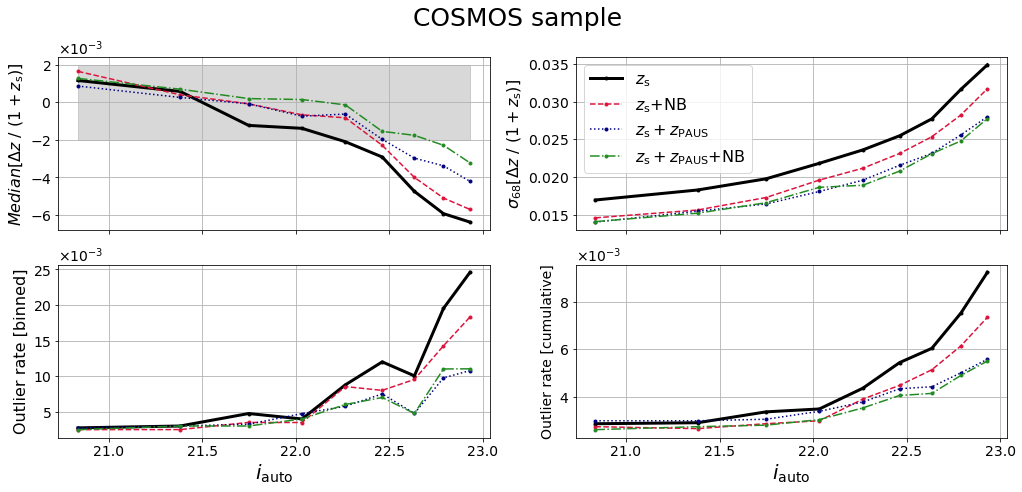

In [76]:
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
fig,ax = plt.subplots(ncols = 2, nrows = 2, sharex=True, figsize = (17,7))
st = fig.suptitle("COSMOS sample", fontsize=25)


from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax[0,0].yaxis.set_major_formatter(formatter) 
ax[0,1].yaxis.set_major_formatter(formatter) 
ax[1,0].yaxis.set_major_formatter(formatter) 
ax[1,1].yaxis.set_major_formatter(formatter) 


ax[0,0].plot(xlab,bias_bb, ls = '-', marker = '.', color = 'black',lw = 3)
ax[0,0].plot(xlab,bias_bbnb, ls = '--', marker = '.', color = 'crimson')
ax[0,0].plot(xlab,bias_bbz, ls = ':', marker = '.', color = 'navy')
ax[0,0].plot(xlab,bias_bbnbz, ls = '-.', marker = '.', color = 'forestgreen')
ax[0,0].fill_between(xlab,-0.002,0.002, color = 'grey', alpha = 0.3)



ax[0,1].plot(xlab,s68_bb, ls = '-', marker = '.', color = 'black',lw = 3, label = r'$z_{\rm s}$')
ax[0,1].plot(xlab,s68_bbnb, ls = '--', marker = '.', color = 'crimson', label = r'$z_{\rm s}$+NB')
ax[0,1].plot(xlab,s68_bbz, ls = ':', marker = '.', color = 'navy', label = r'$z_{\rm s}+z_{\rm PAUS}$')
ax[0,1].plot(xlab,s68_bbnbz, ls = '-.', marker = '.', color = 'forestgreen', label = r'$z_{\rm s}+z_{\rm PAUS}$+NB')
#ax[0,1].fill_between(xlab,0,0.05, color = 'grey', alpha = 0.3)


ax[1,0].plot(xlab,outliers_bb, ls = '-', marker = '.', color = 'black',lw = 3)
ax[1,0].plot(xlab,outliers_bbnb, ls = '--', marker = '.', color = 'crimson')
ax[1,0].plot(xlab,outliers_bbz, ls = ':', marker = '.', color = 'navy')
ax[1,0].plot(xlab,outliers_bbnbz, ls = '-.', marker = '.', color = 'forestgreen')

ax[1,1].plot(xlab,outliers_bb_cum, ls = '-', marker = '.', color = 'black',lw = 3)
ax[1,1].plot(xlab,outliers_bbnb_cum, ls = '--', marker = '.', color = 'crimson')
ax[1,1].plot(xlab,outliers_bbz_cum, ls = ':', marker = '.', color = 'navy')
ax[1,1].plot(xlab,outliers_bbnbz_cum, ls = '-.', marker = '.', color = 'forestgreen')

ax[0,1].legend(fontsize = 16)

ax[0,0].grid()
ax[1,0].grid()
ax[0,1].grid()
ax[1,1].grid()


ax[0,0].set_ylabel(r'$Median[\Delta z\ /\ (1 + z_{\rm s})]$', fontsize = 16)
ax[0,1].set_ylabel(r'$\sigma_{68}[\Delta z\ /\ (1 + z_{\rm s})]$', fontsize = 16)
ax[1,0].set_ylabel(r'Outlier rate [binned]', fontsize = 16)
ax[1,1].set_ylabel(r'Outlier rate [cumulative]', fontsize = 14)
ax[1,1].set_xlabel(r'$i_{\rm auto}$', fontsize = 20)
ax[1,0].set_xlabel(r'$i_{\rm auto}$', fontsize = 20)



plt.savefig('/data/astro/scratch/lcabayol/Euclid/referee_report/figures/cosmos_imag.pdf', bbox_inches = 'tight')


In [77]:
from scipy import stats
dfplot = df_zs.copy()
bin_edges = stats.mstats.mquantiles(dfplot.zb_true, np.arange(0.1,1.01,0.1))
#bin_edges = np.arange(16,25.1,1)

xlab, s68_bb, s68_bbnb, s68_bbz, s68_bbnbz = [],[],[],[], []
outliers_bb, outliers_bbnb, outliers_bbz, outliers_bbnbz = [],[],[],[]
bias_bb, bias_bbnb, bias_bbz, bias_bbnbz  = [],[], [],[]
outliers_bb_cum, outliers_bbnb_cum, outliers_bbz_cum, outliers_bbnbz_cum = [],[],[],[]



for k in range(len(bin_edges)-1):
    edge_min = bin_edges[k]
    edge_max = bin_edges[k+1]
    
    mean_mag =  (edge_max + edge_min) / 2
    
    df_bin = dfplot[(dfplot.zb_true > edge_min) & (dfplot.zb_true < edge_max)]
    df_bin_cum = dfplot[(dfplot.zb_true < edge_max)]

    
    xlab.append(mean_mag)
    s68_bb.append(sigma68(df_bin.rerr_bb))
    s68_bbnb.append(sigma68(df_bin.rerr_bbnb))
    s68_bbz.append(sigma68(df_bin.rerr_bbz))
    s68_bbnbz.append(sigma68(df_bin.rerr_bbnbz))

    
    bias_bb.append(np.nanmedian(df_bin.rerr_bb))
    bias_bbnb.append(np.nanmedian(df_bin.rerr_bbnb))
    bias_bbz.append(np.nanmedian(df_bin.rerr_bbz))
    bias_bbnbz.append(np.nanmedian(df_bin.rerr_bbnbz))

    
    
    outliers_bb.append(len(df_bin[np.abs(df_bin.rerr_bb)>0.15])/len(df_bin))
    outliers_bbnb.append(len(df_bin[np.abs(df_bin.rerr_bbnb)>0.15])/len(df_bin))
    outliers_bbz.append(len(df_bin[np.abs(df_bin.rerr_bbz)>0.15])/len(df_bin))
    outliers_bbnbz.append(len(df_bin[np.abs(df_bin.rerr_bbnbz)>0.15])/len(df_bin))
    
    outliers_bb_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bb)>0.15])/len(df_bin_cum))
    outliers_bbnb_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bbnb)>0.15])/len(df_bin_cum))
    outliers_bbz_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bbz)>0.15])/len(df_bin_cum))
    outliers_bbnbz_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bbnbz)>0.15])/len(df_bin_cum))



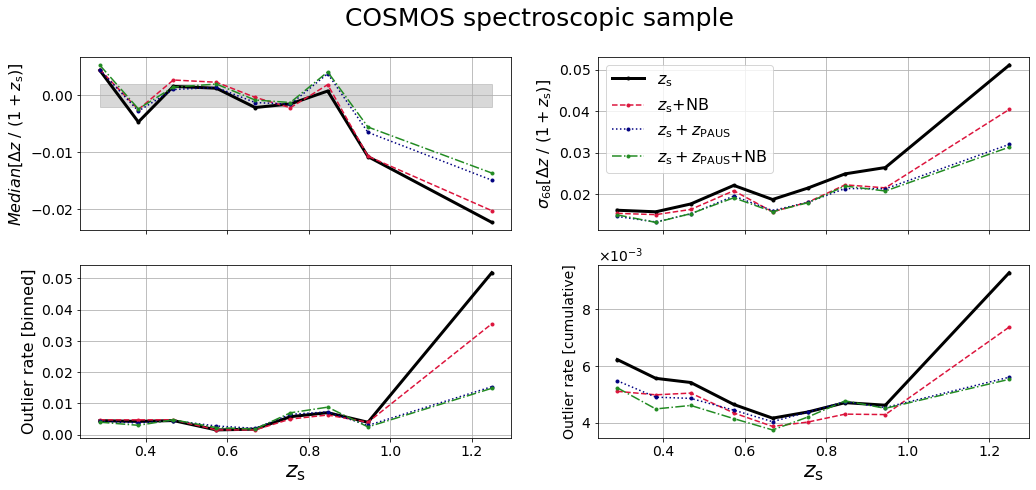

In [83]:
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
fig,ax = plt.subplots(ncols = 2, nrows = 2, sharex=True, figsize = (17,7))
st = fig.suptitle("COSMOS spectroscopic sample", fontsize=25)


from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax[0,0].yaxis.set_major_formatter(formatter) 
ax[0,1].yaxis.set_major_formatter(formatter) 
ax[1,0].yaxis.set_major_formatter(formatter) 
ax[1,1].yaxis.set_major_formatter(formatter) 


ax[0,0].plot(xlab,bias_bb, ls = '-', marker = '.', color = 'black',lw = 3)
ax[0,0].plot(xlab,bias_bbnb, ls = '--', marker = '.', color = 'crimson')
ax[0,0].plot(xlab,bias_bbz, ls = ':', marker = '.', color = 'navy')
ax[0,0].plot(xlab,bias_bbnbz, ls = '-.', marker = '.', color = 'forestgreen')
ax[0,0].fill_between(xlab,-0.002,0.002, color = 'grey', alpha = 0.3)



ax[0,1].plot(xlab,s68_bb, ls = '-', marker = '.', color = 'black',lw = 3, label = r'$z_{\rm s}$')
ax[0,1].plot(xlab,s68_bbnb, ls = '--', marker = '.', color = 'crimson', label = r'$z_{\rm s}$+NB')
ax[0,1].plot(xlab,s68_bbz, ls = ':', marker = '.', color = 'navy', label = r'$z_{\rm s}+z_{\rm PAUS}$')
ax[0,1].plot(xlab,s68_bbnbz, ls = '-.', marker = '.', color = 'forestgreen', label = r'$z_{\rm s}+z_{\rm PAUS}$+NB')
#ax[0,1].fill_between(xlab,0,0.05, color = 'grey', alpha = 0.3)


ax[1,0].plot(xlab,outliers_bb, ls = '-', marker = '.', color = 'black',lw = 3)
ax[1,0].plot(xlab,outliers_bbnb, ls = '--', marker = '.', color = 'crimson')
ax[1,0].plot(xlab,outliers_bbz, ls = ':', marker = '.', color = 'navy')
ax[1,0].plot(xlab,outliers_bbnbz, ls = '-.', marker = '.', color = 'forestgreen')

ax[1,1].plot(xlab,outliers_bb_cum, ls = '-', marker = '.', color = 'black',lw = 3)
ax[1,1].plot(xlab,outliers_bbnb_cum, ls = '--', marker = '.', color = 'crimson')
ax[1,1].plot(xlab,outliers_bbz_cum, ls = ':', marker = '.', color = 'navy')
ax[1,1].plot(xlab,outliers_bbnbz_cum, ls = '-.', marker = '.', color = 'forestgreen')

ax[0,1].legend(fontsize = 16)

ax[0,0].grid()
ax[1,0].grid()
ax[0,1].grid()
ax[1,1].grid()


ax[0,0].set_ylabel(r'$Median[\Delta z\ /\ (1 + z_{\rm s})]$', fontsize = 16)
ax[0,1].set_ylabel(r'$\sigma_{68}[\Delta z\ /\ (1 + z_{\rm s})]$', fontsize = 16)
ax[1,0].set_ylabel(r'Outlier rate [binned]', fontsize = 16)
ax[1,1].set_ylabel(r'Outlier rate [cumulative]', fontsize = 14)
#ax[1,1].set_xlabel(r'$z_{\rm PAUS+Cosmos}$', fontsize = 22)
#ax[1,0].set_xlabel(r'$z_{\rm PAUS+Cosmos}$', fontsize = 22)
ax[1,1].set_xlabel(r'$z_{\rm s}$', fontsize = 22)
ax[1,0].set_xlabel(r'$z_{\rm s}$', fontsize = 22)

plt.savefig('/data/astro/scratch/lcabayol/Euclid/referee_report/figures/cosmos_zs_zs.pdf', bbox_inches = 'tight')


## PLOTS FLAGSHIP

In [ ]:
from scipy import stats

bin_edges = stats.mstats.mquantiles(df.mag, np.arange(0.1,1.01,0.1))
#bin_edges = np.arange(16,25.1,1)

xlab, s68_bb, s68_bbnb, s68_bbz, s68_bbnbz = [],[],[],[], []
outliers_bb, outliers_bbnb, outliers_bbz, outliers_bbnbz = [],[],[],[]
bias_bb, bias_bbnb, bias_bbz, bias_bbnbz  = [],[], [],[]
outliers_bb_cum, outliers_bbnb_cum, outliers_bbz_cum, outliers_bbnbz_cum = [],[],[],[]



for k in range(len(bin_edges)-1):
    edge_min = bin_edges[k]
    edge_max = bin_edges[k+1]
    
    mean_mag =  (edge_max + edge_min) / 2
    
    df_bin = df[(df.mag > edge_min) & (df.mag < edge_max)]
    df_bin_cum = df[(df.mag < edge_max)]

    
    xlab.append(mean_mag)
    s68_bb.append(sigma68(df_bin.rerr_bb))
    s68_bbnb.append(sigma68(df_bin.rerr_bbnb))
    s68_bbz.append(sigma68(df_bin.rerr_bbz))
    s68_bbnbz.append(sigma68(df_bin.rerr_bbnbz))

    
    bias_bb.append(np.nanmedian(df_bin.rerr_bb))
    bias_bbnb.append(np.nanmedian(df_bin.rerr_bbnb))
    bias_bbz.append(np.nanmedian(df_bin.rerr_bbz))
    bias_bbnbz.append(np.nanmedian(df_bin.rerr_bbnbz))

    
    
    outliers_bb.append(len(df_bin[np.abs(df_bin.rerr_bb)>0.15])/len(df_bin))
    outliers_bbnb.append(len(df_bin[np.abs(df_bin.rerr_bbnb)>0.15])/len(df_bin))
    outliers_bbz.append(len(df_bin[np.abs(df_bin.rerr_bbz)>0.15])/len(df_bin))
    outliers_bbnbz.append(len(df_bin[np.abs(df_bin.rerr_bbnbz)>0.15])/len(df_bin))
    
    outliers_bb_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bb)>0.15])/len(df))
    outliers_bbnb_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bbnb)>0.15])/len(df))
    outliers_bbz_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bbz)>0.15])/len(df))
    outliers_bbnbz_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bbnbz)>0.15])/len(df))

